In [1]:
import numpy as np
from matplotlib import pyplot as plt
from groupyr import LogisticSGL
import pandas as pd


In [2]:
def mark_as_categorical(dataframe: pd.DataFrame, category: str):
    dataframe[category] = dataframe[category].astype('category')

def get_categories(dataframe: pd.DataFrame):
    return [col for col in dataframe.select_dtypes(include="category")]

In [3]:
def create_groups_from_1hot(data_frame: pd.DataFrame):
    expanded = pd.get_dummies(data_frame)
    groups = {col: [] for col in data_frame}
    for idx, col in enumerate(expanded):
        category = col.split("_")[0]
        groups[category].append(idx)

    groups = {k: np.array(v) for k, v in groups.items()}
    return expanded, groups

In [4]:
kid_data = pd.read_csv("data.csv", delimiter=";")

In [5]:
mark_as_categorical(kid_data, "MaritalStatus")
mark_as_categorical(kid_data, "ApplicationMode")
mark_as_categorical(kid_data, "ApplicationOrder")
mark_as_categorical(kid_data, "TimeOfDay")
mark_as_categorical(kid_data, "PreviousQualification")
mark_as_categorical(kid_data, "Nationality")
mark_as_categorical(kid_data, "MotherQualification")
mark_as_categorical(kid_data, "FatherQualification")
mark_as_categorical(kid_data, "MotherOccupation")
mark_as_categorical(kid_data, "FatherOccupation")
mark_as_categorical(kid_data, "Course")
target = kid_data.get("Target").replace(['Dropout', 'Graduate', 'Enrolled'], [0, 1, 1]).astype(float),


for col in kid_data.select_dtypes(include="float64", exclude="category"):
    kid_data[col] /= kid_data[col].max()

expanded_X, group_idxs = create_groups_from_1hot(kid_data.drop(columns="Target"))
expanded_X

,PreviousGrade,AdmissionGrade,Displaced,SpecialNeeds,Debtor,TuitionPaid,Gender,Scholarship,Age,International,...,FatherOccupation_172,FatherOccupation_174,FatherOccupation_175,FatherOccupation_181,FatherOccupation_182,FatherOccupation_183,FatherOccupation_192,FatherOccupation_193,FatherOccupation_194,FatherOccupation_195
0,0.642105,0.670000,1,0,0,1,1,0,20,0,...,0,0,0,0,0,0,0,0,0,0
1,0.842105,0.750000,1,0,0,0,1,0,19,0,...,0,0,0,0,0,0,0,0,0,0
2,0.642105,0.656842,1,0,0,0,1,0,19,0,...,0,0,0,0,0,0,0,0,0,0
3,0.642105,0.629474,1,0,0,1,0,0,20,0,...,0,0,0,0,0,0,0,0,0,0
4,0.526316,0.744737,0,0,0,1,0,0,45,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,0.657895,0.643158,0,0,0,1,1,0,19,0,...,0,0,0,0,0,0,0,0,0,0
4420,0.631579,0.626316,1,0,1,0,0,0,18,1,...,0,0,0,0,0,0,0,0,0,0
4421,0.810526,0.786842,1,0,0,1,0,1,30,0,...,0,0,0,0,0,0,0,0,0,0
4422,0.947368,0.809474,1,0,0,1,0,1,20,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
kid_data.get("Target").value_counts()*0.8

Graduate    1767.2
Dropout     1136.8
Enrolled     635.2
Name: Target, dtype: float64

In [7]:
get_categories(kid_data)

['MaritalStatus',
 'ApplicationMode',
 'ApplicationOrder',
 'Course',
 'TimeOfDay',
 'PreviousQualification',
 'Nationality',
 'MotherQualification',
 'FatherQualification',
 'MotherOccupation',
 'FatherOccupation']

In [15]:
from groupyr import LogisticSGLCV
from sklearn.model_selection import train_test_split


X = expanded_X.to_numpy(np.float64)
y = kid_data['Target'].replace(['Dropout', 'Graduate', 'Enrolled'], [1, 0, 2]).to_numpy(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

(3539, 255)
(3539,)


In [ ]:
group_model = LogisticSGL(groups=list(group_idxs.values()), l1_ratio=1, alpha=0.01,
    verbose=2, suppress_solver_warnings=False, max_iter=10000
).fit(X_train, y_train)

In [9]:
import sklearn.metrics as metrics
y_pred = group_model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred))
print(group_model.score(X_test, y_test))

[[582  31]
 [ 88 184]]
0.7556468172484601
0.8655367231638418


In [10]:
np.mean(y)

0.3212025316455696

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='none', max_iter=10000).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
#print(metrics.f1_score(y_test, y_pred))
print(model.score(X_test, y_test))

[[402  16  26]
 [ 48 216  22]
 [ 66  37  52]]
0.7570621468926554


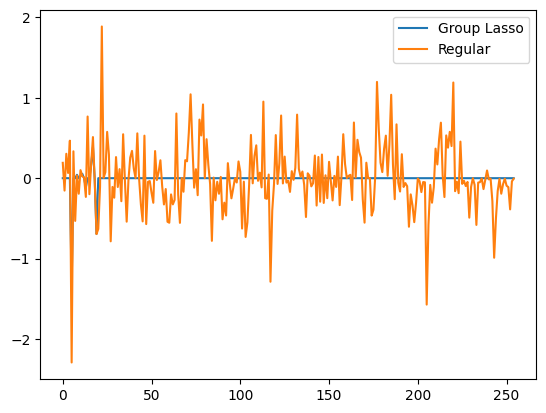

In [12]:
plt.plot(group_model.coef_, label="Group Lasso")
plt.plot(model.coef_.squeeze(), label="Regular")
plt.legend()

In [13]:
print(expanded_X.columns[abs(group_model.coef_) > 1e-3])
print(expanded_X.columns[np.argmax(abs(group_model.coef_))])

Index(['TuitionPaid', 'Scholarship', 'Age',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (approved)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)'],
      dtype='object')
TuitionPaid


In [22]:
np.mean(kid_data['Curricular units 1st sem (evaluations)'] >= kid_data['Curricular units 1st sem (enrolled)'])

0.9617992766726944

Try running regular logistic regression in scikit with multiclass class and compare results
Logistic Regression
SVM
A boosted method from their paper
Completely redo the basic scikit learn classifiers
Try a neural network
Jared and Jordan

Stretch - Investigate adding multiclass classification to groupyr
Weighting of classes by size in groupyr
-Alec

Try PCA and LogisticPCA to do feature extraction
TBD - (Alec)
Backward AIC regression
Jared

Plot correlations of variables
Jordan

Report:
Write background/motivation sections
